In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Multiply, Reshape, Add

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
data_dir = '/content/drive/MyDrive/balanced_dataset7'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

In [ ]:
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

In [ ]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [ ]:
import os
from PIL import Image

def check_images(directory):
    """Checks images in a directory and removes corrupted ones."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify if the image can be opened
            except (IOError, SyntaxError):
                print(f"Corrupted file detected and removed: {file_path}")
                os.remove(file_path)  # Remove the corrupted file

# Run the check on train and validation directories
check_images("/content/drive/MyDrive/balanced_dataset7/train")
check_images("/content/drive/MyDrive/balanced_dataset7/val")

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) # Normalize pixel values to [0, 1]


# Create an ImageDataGenerator for validation (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of tensor image data for training and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical',  # 'binary' for binary classification, 'categorical' for multi-class
    shuffle=True,
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    class_mode='categorical',  # 'binary' for binary classification, 'categorical' for multi-class
    shuffle=False,
    seed=42
)

Found 30474 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Add,
    Reshape,
    Multiply,
    Conv2D,
    Input,
    Dropout,
    Lambda,  # Import Lambda
)

def cbam_block(input_feature, ratio=8):
    """CBAM Attention: Channel and Spatial Attention"""
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu', use_bias=False)
    shared_layer_two = Dense(channel, use_bias=False)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = tf.keras.layers.Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    channel_refined = Multiply()([input_feature, channel_attention])

    # Spatial Attention
    # Wrap tf.reduce_mean and tf.reduce_max in Lambda layers
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])

    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature

def create_model_with_cbam_resnet50():
    """Creates a ResNet50V2 model with CBAM blocks and modifications for a 4-class classification task."""

    resnet_model = tf.keras.applications.resnet_v2.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the first layers (adjust as needed)
    for layers in resnet_model.layers[:100]:  # You can adjust the number of frozen layers here.
        layers.trainable = False
    # Make the remaining layers trainable
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output

    # Apply CBAM block after a convolutional block (adjust as needed)
    x = cbam_block(x)

    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Output layer with 4 classes and softmax activation
    predictions = Dense(4, activation='softmax')(x)

    # Create the final model
    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compile the model
    res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return res_model

In [ ]:
res_model= create_model_with_cbam_resnet50()
res_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 26,975,079 (102.90 MB)

 Trainable params: 23,970,151 (91.44 MB)

 Non-trainable params: 3,004,928 (11.46 MB)

In [ ]:
history = res_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 156s 126ms/step - accuracy: 0.6324 - loss: 0.7889 - val_accuracy: 0.6685 - val_loss: 2.4211
Epoch 2/100
  1/952 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.8438 - loss: 0.4602

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8438 - loss: 0.4602 - val_accuracy: 0.6850 - val_loss: 1.8308
Epoch 3/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 98s 103ms/step - accuracy: 0.8085 - loss: 0.4434 - val_accuracy: 0.9133 - val_loss: 0.1843
Epoch 4/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9688 - loss: 0.1950 - val_accuracy: 0.9155 - val_loss: 0.1838
Epoch 5/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 99s 104ms/step - accuracy: 0.9062 - loss: 0.2451 - val_accuracy: 0.9373 - val_loss: 0.1656
Epoch 6/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9688 - loss: 0.0607 - val_accuracy: 0.9305 - val_loss: 0.1865
Epoch 7/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 99s 104ms/step - accuracy: 0.9483 - loss: 0.1430 - val_accuracy: 0.9695 - val_loss: 0.0945
Epoch 8/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9688 - loss: 0.0663 - val_accuracy: 0.9682 - val_loss: 0.0966
Epoch 9/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 99s 104ms/step - accuracy: 0.9608 - loss: 0.1229 - 

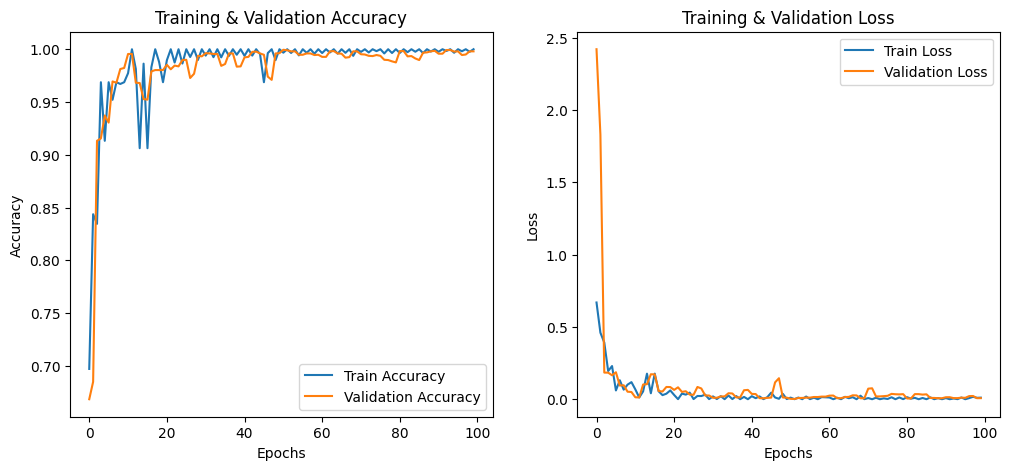

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

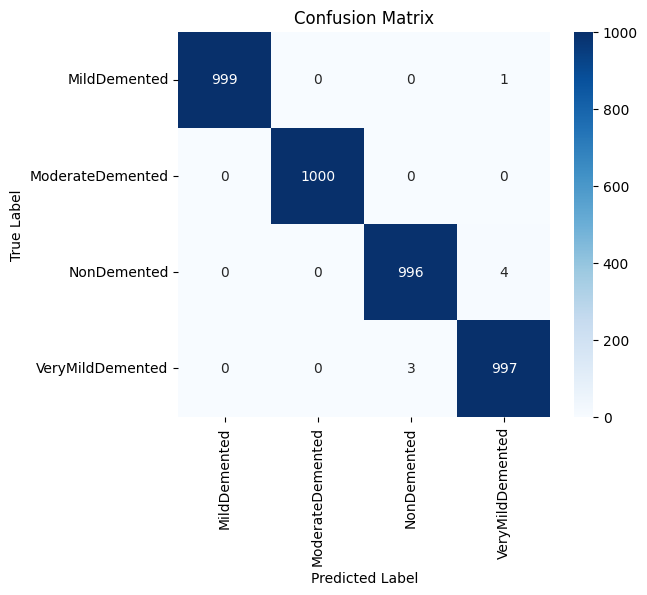

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1000
ModerateDemented       1.00      1.00      1.00      1000
     NonDemented       1.00      1.00      1.00      1000
VeryMildDemented       1.00      1.00      1.00      1000

        accuracy                           1.00      4000
       macro avg       1.00      1.00      1.00      4000
    weighted avg       1.00      1.00      1.00      4000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.show()

# Confusion matrix plot
def plot_confusion_matrix(model, validation_generator, categories):
    # Get true labels and predictions
    true_labels = []
    pred_labels = []

    for batch, labels in validation_generator:
        preds = model.predict(batch)
        pred_labels.extend(np.argmax(preds, axis=1))
        true_labels.extend(np.argmax(labels, axis=1))

        if len(true_labels) >= validation_generator.samples:
            break  # Stop when all validation samples are processed

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=categories))

# Define category names
CATEGORIES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Call the functions after training
plot_training_curves(history)
plot_confusion_matrix(res_model, validation_generator, CATEGORIES)

In [ ]:
# Evaluate on the test set (using validation_generator)
test_loss, test_acc = res_model.evaluate(validation_generator)  # Changed to validation_generator
print(f"\n🔍 Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9987 - loss: 0.0040

🔍 Test Accuracy: 0.9980
📉 Test Loss: 0.0075


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


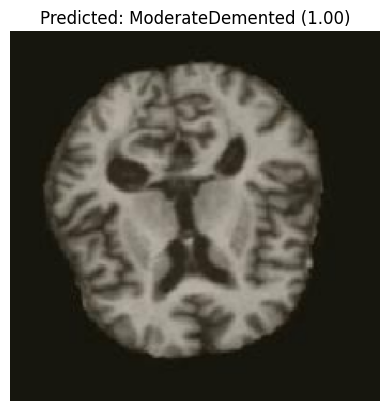

In [ ]:
# Single Image Prediction Function
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = CATEGORIES[np.argmax(pred)]
    confidence = np.max(pred)

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example Single Image Prediction
predict_single_image("/content/drive/MyDrive/dataset_balanced2/train/ModerateDemented/0_2911fdc4-0a04-4722-96f1-cb9b1aee7d24.jpg", res_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


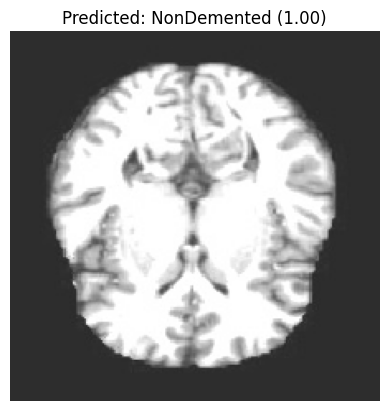

In [ ]:
# Single Image Prediction Function
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = CATEGORIES[np.argmax(pred)]
    confidence = np.max(pred)

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example Single Image Prediction
predict_single_image("/content/drive/MyDrive/dataset_balanced/train/NonDemented/1004_618daa24-f598-4e59-a364-0a1f917a9e4a.jpg", res_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


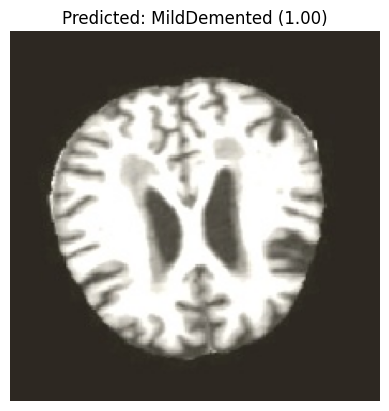

In [ ]:
# Single Image Prediction Function
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = CATEGORIES[np.argmax(pred)]
    confidence = np.max(pred)

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example Single Image Prediction
predict_single_image("/content/drive/MyDrive/dataset_balanced/train/MildDemented/1003_692b24f2-6724-48c4-bd18-51e7a153f70b.jpg", res_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


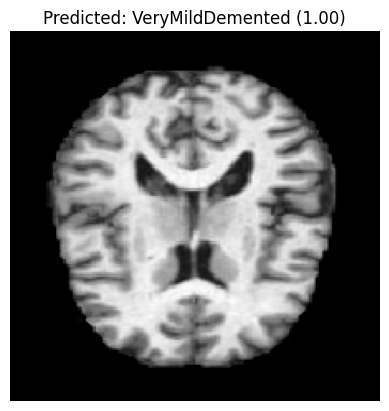

In [ ]:
 #Single Image Prediction Function
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = CATEGORIES[np.argmax(pred)]
    confidence = np.max(pred)

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# Example Single Image Prediction
predict_single_image("/content/drive/MyDrive/dataset_balanced/train/VeryMildDemented/1000_8ccbbfe1-2cfa-4f54-9548-3a915c1ff311.jpg", res_model)